# <center> Customer Segmentation - Clustering

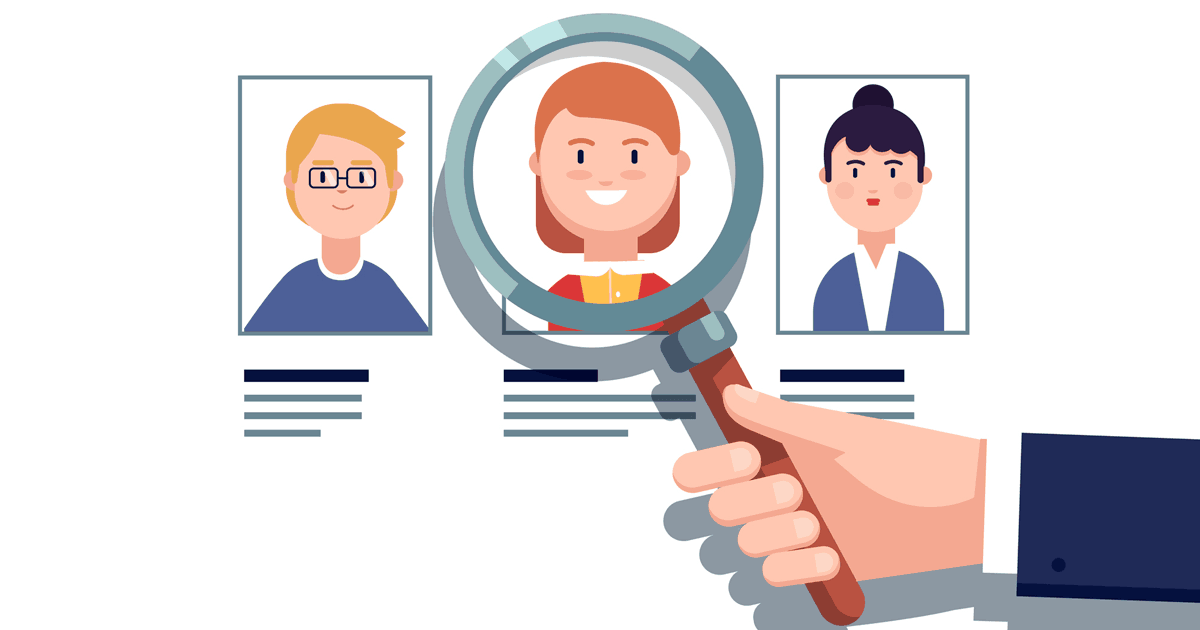

## Introduction

In this project, I will be performing an unsupervised clustering of data on the customer's records from a  automobile company's [database](https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation). Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster. I will divide customers into segments to optimize the significance of each customer to the business. To modify products according to distinct needs and behaviours of the customers. It also helps the business to cater to the concerns of different types of customers. Firstly, I'll do a data wrangling to deal with inconsistences in the data, the a basic exploration in the data to underestend it, and finally perform clustering techniques.

**Data content:**

* **ID**: Unique ID
* **Gender**: Gender of the customer
* **Ever_Married**: Marital status of the customer
* **Age**: Age of the customer
* **Graduated**: Is the customer a graduate?
* **Profession**: Profession of the customer
* **Work_Experience**: Work Experience in years
* **Spending_Score**: Spending score of the customer
* **Family_Size**: Number of family members for the customer (including the customer)
* **Var_1**: Anonymised Category for the customer
* **Segmentation**: (target) Customer Segment of the customer

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='viridis',
#              font='Lucida Calligraphy',
#              font_scale=1.3,
              color_codes=True,
              rc=None)
import warnings
warnings.filterwarnings('ignore')

# Plotly visualization
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
pio.templates.default = "plotly_white"

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy

from yellowbrick.cluster import KElbowVisualizer
import pylab

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

init_notebook_mode(connected=True) # to display plotly graph offline

%matplotlib inline

### Functions

In [2]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

### Dataset

In [3]:
df = pd.read_csv('Customer_Segmentation-Train.csv')

In [4]:
df.head()

ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [6]:
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='viridis')

In [7]:
df.describe(include=['object']).T.style.background_gradient(subset=['unique','freq'], cmap='viridis')

* The dataset contains 11 columns with 8067 observations, and there missing values in some columns.
* There are some categorical features in our data - features in Dtype: object. So we will need to encode them into numeric later.
* Columns `ID`, `Var_1` and `Segmentation` will be droped.
* However, the data types for some columns are not matched. Below will fixed the data types for those column before analysis performed.

## Data Wrangling

In this section will be done some data cleaning. First of all, for the missing values, I am simply going to drop the rows that have missing values as the objetive of this project is clutering. Also, I am droping ID, Var_1 and Segmentation features.

In [8]:
for col in df.select_dtypes('object').columns:
    print('\033[1m' + col + '\033[0m', '\n')
    print(df[col].unique(), '\n')

Gender 

['Male' 'Female'] 

Ever_Married 

['No' 'Yes' nan] 

Graduated 

['No' 'Yes' nan] 

Profession 

['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Spending_Score 

['Low' 'Average' 'High'] 

Var_1 

['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Segmentation 

['D' 'A' 'B' 'C'] 



In [9]:
df.drop(['ID', 'Var_1', 'Segmentation'], axis=1, inplace=True)

In [10]:
df[df.isnull().any(axis=1)]

Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
1     Female          Yes   38       Yes       Engineer              NaN   
4     Female          Yes   40       Yes  Entertainment              NaN   
12    Female           No   19        No      Executive              0.0   
13      Male          Yes   70        No         Lawyer              NaN   
24    Female          NaN   58        No      Executive              1.0   
...      ...          ...  ...       ...            ...              ...   
8040  Female           No   25        No      Homemaker              NaN   
8044  Female          NaN   50        No       Engineer              1.0   
8047    Male          Yes   50       Yes         Doctor              NaN   
8049  Female          Yes   81        No         Lawyer              NaN   
8063    Male           No   22        No            NaN              0.0   

     Spending_Score  Family_Size  
1           Average          3.0  
4              High          6.0  
12              Low          NaN  
13              Low          1.0  
24          Average          3.0  
...             ...          ...  
8040            Low          1.0  
8044            Low          2.0  
8047        Average          2.0  
8049           High          2.0  
8063            Low          7.0  

[1350 rows x 8 columns]

On the missing data, values such as average, most frequent, or assumptions can be made - assign no experience to those who do not have a degree or to those with a missing profession assign self-employed, etc - to replace them, however they will be simply excluded so as not to 'influence' the analyses.

In [11]:
df.dropna(inplace=True)

In [12]:
df.reset_index(drop=True, inplace=True)

## Basic Exploratory Data Analysis (EDA)

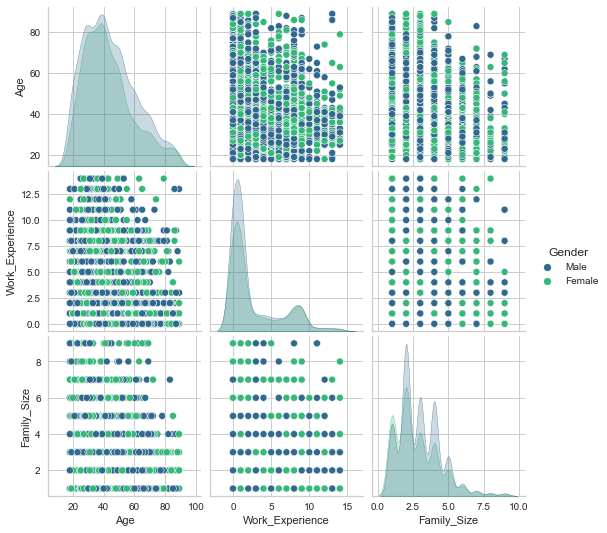

In [13]:
sns.pairplot(df, hue='Gender', palette='viridis'
#             height=5, aspect=0.9
            )

<AxesSubplot:>

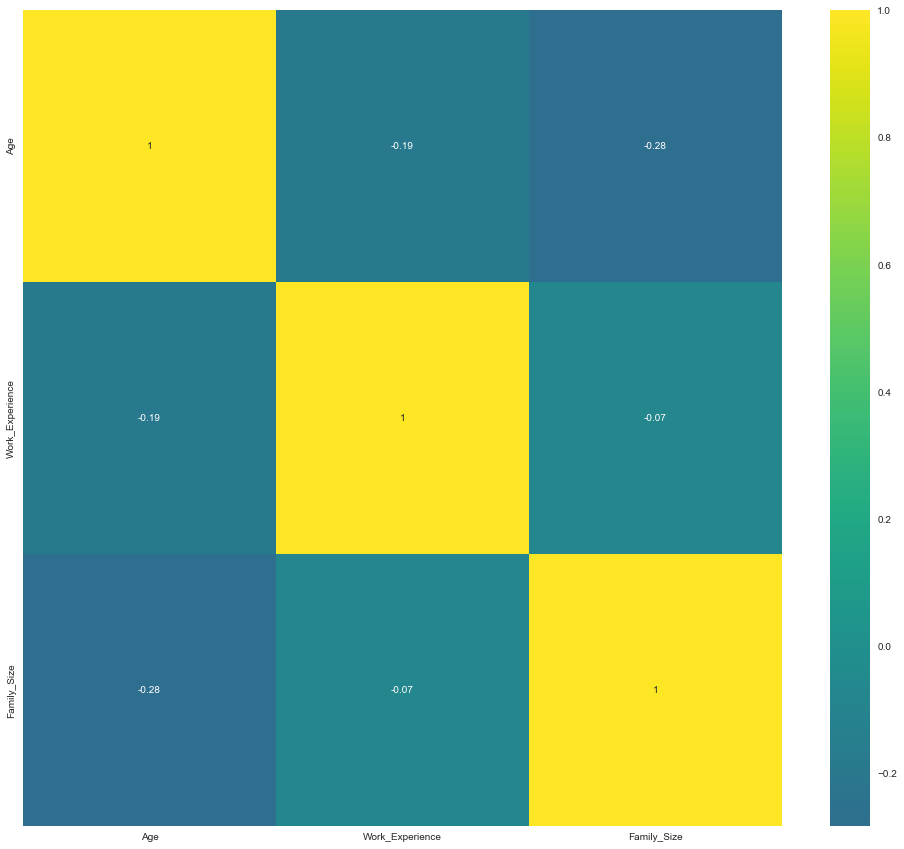

In [14]:
corrmat= df.corr()
plt.figure(figsize=(17,15))  
sns.heatmap(corrmat, annot=True, cmap='viridis', center=0)

<AxesSubplot:xlabel='Family_Size', ylabel='count'>

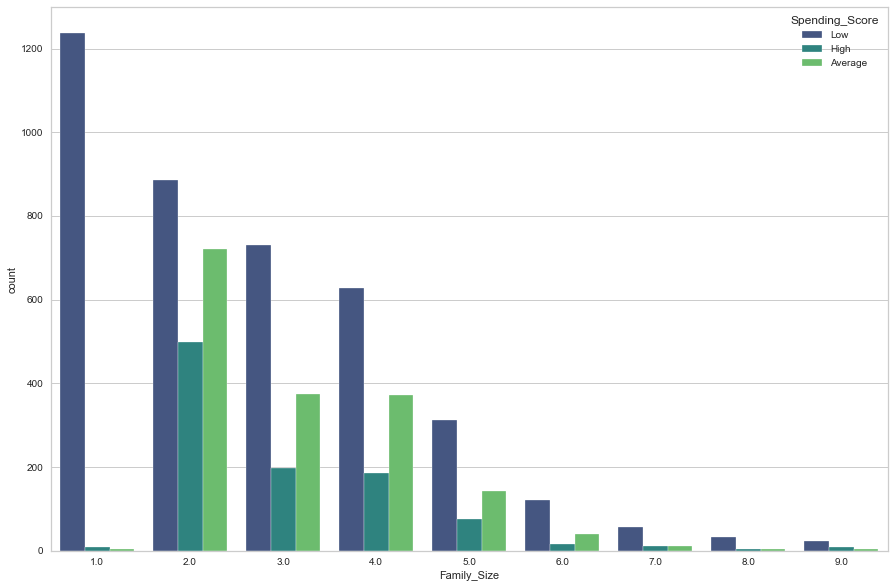

In [15]:
plt.figure(figsize=(15,10))  
sns.countplot(data=df, x='Family_Size', hue='Spending_Score', palette='viridis')

<AxesSubplot:xlabel='Work_Experience', ylabel='Graduated'>

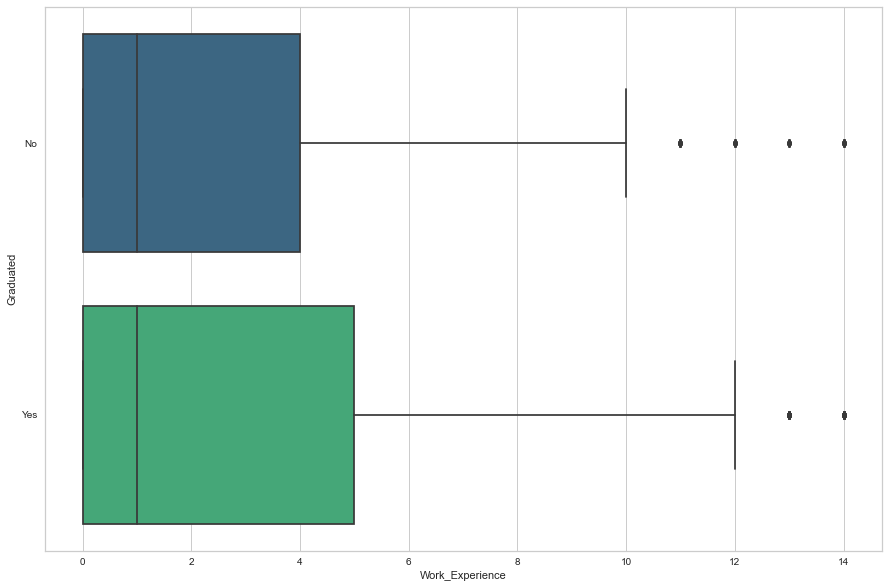

In [16]:
plt.figure(figsize=(15,10))  
sns.boxplot(data=df, x='Work_Experience', y='Graduated', palette='viridis')

In [17]:
df['Profession'].value_counts()

Artist           2211
Healthcare       1089
Entertainment     815
Doctor            594
Engineer          586
Executive         509
Lawyer            503
Marketing         233
Homemaker         178
Name: Profession, dtype: int64

In [18]:
pd.crosstab(df['Profession'], df['Spending_Score'])

Spending_Score  Average  High   Low
Profession                         
Artist              889   214  1108
Doctor              161    23   410
Engineer            179    51   356
Entertainment       275    33   507
Executive            63   344   102
Healthcare           37    35  1017
Homemaker            47    18   113
Lawyer               16   270   217
Marketing            10    24   199

The data is quite clean and the new features have been included. I will proceed to the next step. That is, preprocessing the data.

## Data Preprocessing

**In this section, I will be preprocessing the data to perform clustering operations.**

The following steps are applied to preprocess the data:

* Label encoding the categorical features
* Scaling the features using the standard scaler
* Creating a subset dataframe for dimensionality reduction*

In [19]:
categ_feat = []
num_feat = []

for col in list(df.columns):
    if (df[col].dtype == 'float64') | (df[col].dtype == 'int64'):
        num_feat.append(col)
    
    else:
        categ_feat.append(col)

In [20]:
ds = df.copy()

#Label encoding categorical features
le = LabelEncoder()
for i in categ_feat:
    ds[i] = ds[[i]].apply(le.fit_transform)

In [21]:
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
df_prepreprocessed = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

In [22]:
df_prepreprocessed.head()

Gender  Ever_Married       Age  Graduated  Profession  Work_Experience  \
0  0.902604     -1.203804 -1.303562  -1.324114    0.912982        -0.478692   
1 -1.107905      0.830700  1.421748   0.755222   -0.278357        -0.478692   
2  0.902604      0.830700  1.421748   0.755222    1.707208        -0.772431   
3  0.902604      0.830700  0.755561  -1.324114   -1.072583        -0.772431   
4  0.902604     -1.203804 -0.697937   0.755222    0.912982        -0.478692   

   Spending_Score  Family_Size  
0        0.762325     0.760391  
1        0.762325    -1.209140  
2       -0.410671    -0.552630  
3       -1.583666    -0.552630  
4        0.762325     0.103881

<AxesSubplot:>

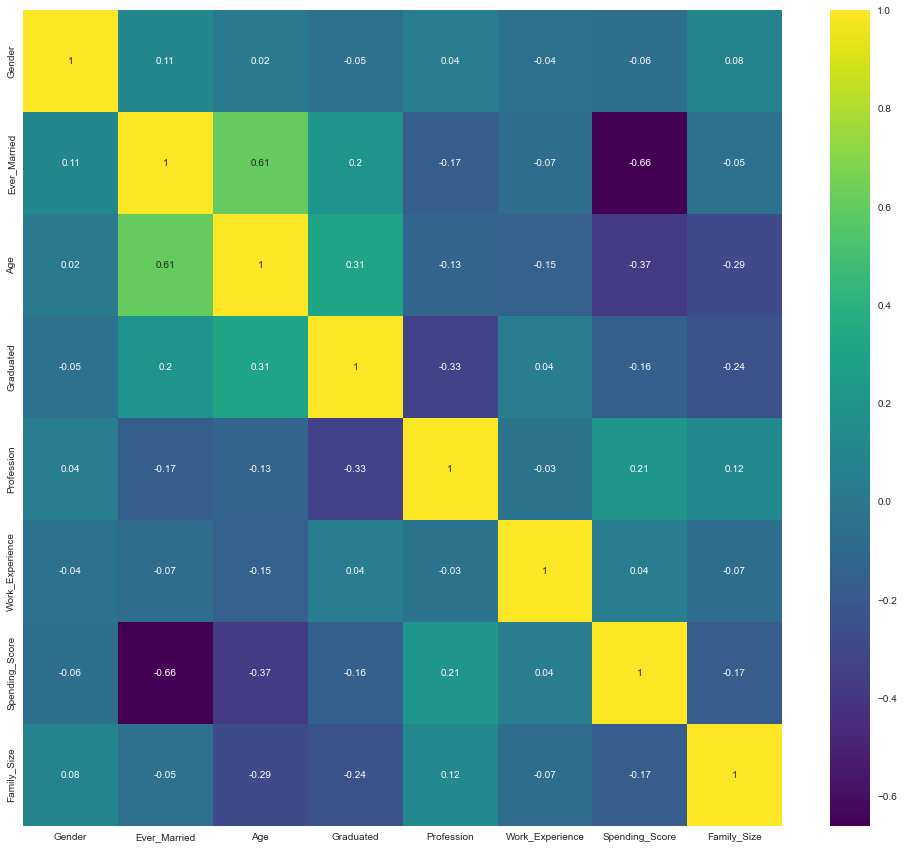

In [23]:
plt.figure(figsize=(17,15))  
sns.heatmap(round(ds.corr(method='spearman'), 2), annot=True,
            mask=None, cmap='viridis')

## Dimensionality Reduction*

As the name implies, Dimensionality Reduction, is an unsupervised machine learning method that aims to reduce the number of variables in a dataset in order to extract the most important information from those used, principal component analysis (PCA) is the method most used.

**Principal component analysis (PCA)** is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

**Steps in this section:**

* Dimensionality reduction with PCA
* Plotting the reduced dataframe

**Dimensionality reduction with PCA**

For this project, I will be reducing the dimensions to 3. Although dimensionality reduction is a more commonly used task for very large databases, it will be used here as an example.

In [24]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(df_prepreprocessed)
PCA_ds = pd.DataFrame(pca.transform(df_prepreprocessed), columns=(['PC1', 'PC2', 'PC3']))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
PC1  6718.0 -1.683017e-16  1.498328 -3.087419 -1.295048 -0.269103  1.268517   
PC2  6718.0 -4.392636e-17  1.162772 -3.385902 -0.788984  0.059284  0.827632   
PC3  6718.0  4.560376e-17  1.080076 -3.219069 -0.738799 -0.073357  0.566205   

          max  
PC1  3.304625  
PC2  4.341337  
PC3  3.394194

In [25]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds['PC1']
y =PCA_ds['PC2']
z =PCA_ds['PC3']
#To plot
fig = px.scatter_3d(PCA_ds, x='PC1', y='PC2', z='PC3',
              #color='Clusters',
                    color_continuous_scale='Viridis')
fig.update_layout(title='A 3D Projection Of Data In The Reduced Dimension')
fig.show()

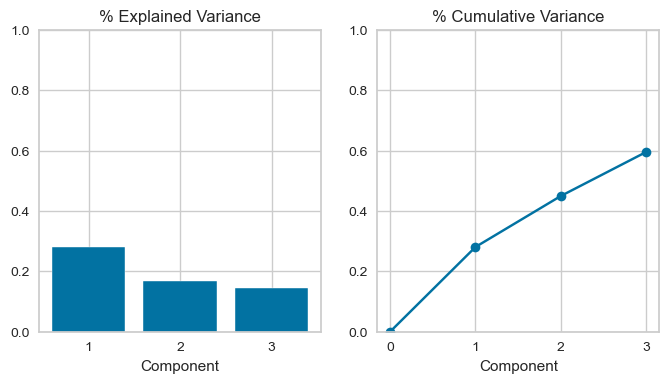

In [26]:
plot_variance(pca);

---

## Clustering

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

**Steps involved in the Clustering**

* Elbow Method to determine the number of clusters to be formed in k-Means
* Clustering via k-Means
* Dendrogram determine the number of clusters to be formed in Agglomerative Clustering
* Clustering via Agglomerative Clustering
* Clustering via DBSCAN
* Vizualisation and examination of the clusters formed in each clustering model

**To make the clustering algorithms will be used the data preprocessed and not the PCA one**.

### <center> k-Means Clustering

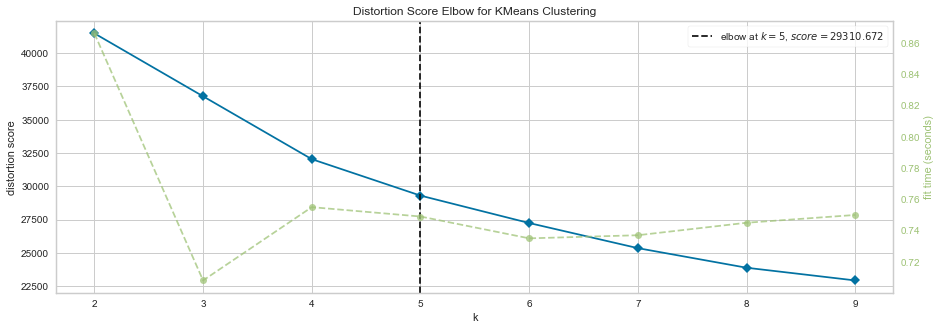

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# check the best number of clusters to make with of elbow method
Elbow_M = KElbowVisualizer(KMeans(random_state=0), k=(2, 10))
plt.figure(figsize=(15,5))  
Elbow_M.fit(df_prepreprocessed)
Elbow_M.show()

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/K-means_convergence.gif/617px-K-means_convergence.gif?20170530143526'>

Source: [File:K-means convergence.gif - Wikimedia Commons](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif) 

The K-means clustering algorithm is one of the most popular unsupervised machine learning algorithms and it is used for data segmentation. It is a clustering algorithm that finds similarities between objects and groups them into K different clusters.

The creation of these clusters is given as follows:
1. determine the number, k of clusters and centroids (usually randomly selected)
2. calculate distance from each data point from each of the centroids
3. assign each data point to the closest centroid, which becomes a member of that cluster
4. New centroids are calculated for the formed clusters
5. repeat the process until there are no more changes, that is, the algorithm has reached the lowest possible error - as in the example in the image above.

Note that in k-Means it's needed to informe the number of clusters... [video coursera]

In [28]:
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12)

In [29]:
k_means.fit(df_prepreprocessed)

KMeans(n_clusters=5, n_init=12)

In [30]:
df['k-Means Clusters'] = k_means.labels_

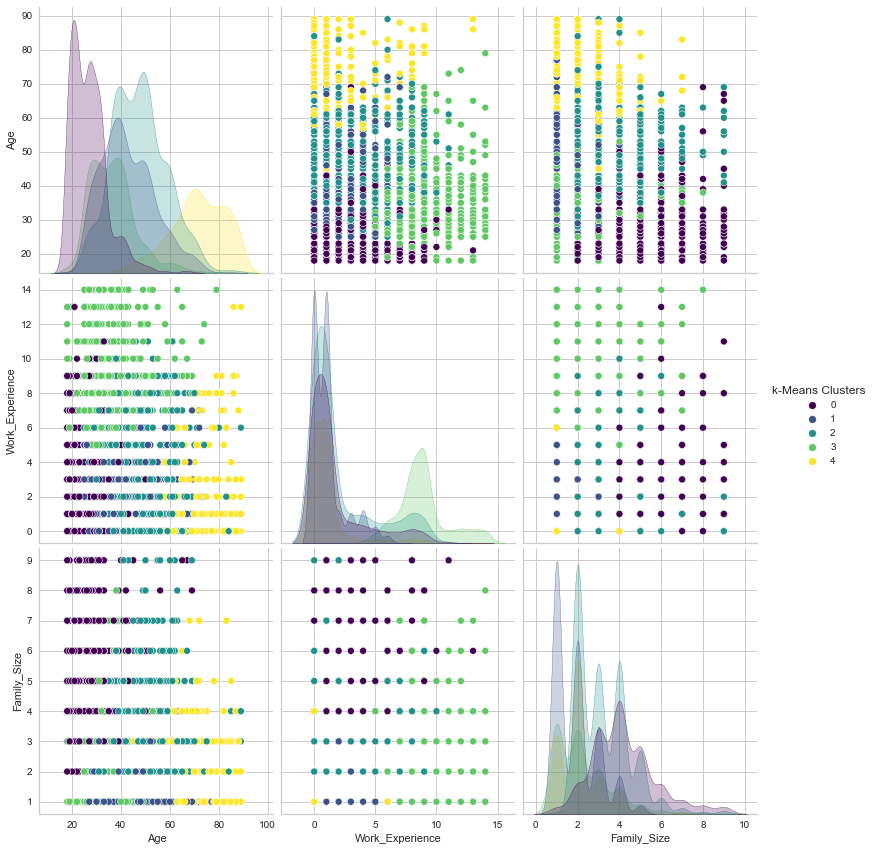

In [31]:
sns.pairplot(df, height=4, hue='k-Means Clusters', aspect=0.9, palette='viridis')

In [32]:
fig = px.scatter_3d(df, x='Work_Experience', y='Family_Size', z='Age',
              color='k-Means Clusters', color_continuous_scale='Viridis')

fig.show()

### <center> Hierarquical Clustering

<img src='https://miro.medium.com/max/1480/1*VvOVxdBb74IOxxF2RmthCQ.png'>

Source: [Hierarchical clustering explained | by Prasad Pai | Towards Data Science](https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8) 

"Hierarchical clustering algorithms build a hierarchy of clusters where each node is a cluster consisting of the clusters of its daughter nodes. Strategies for hierarchical clustering generally fall into two types, divisive and agglomerative. Divisive is top down, so you start with all observations in a large cluster and break it down into smaller pieces. Agglomerative is the opposite of divisive. So it is bottom up, where each observation starts in its own cluster and pairs of clusters are merged together as they move up the hierarchy. Agglomeration means to amass or collect things, which is exactly what this does with the cluster." The agglomerative approach is more popular and so it is the one used here.
The difference from k-Means is that Hierarchical Clustering the number of clusters doen't have to be specified.

The creation of agglomerative clusters is given as follows:
1. create n clusters, one for each data point
2. calculate the proximity matrix (matrix with distance between each pair of data points)
3. iterate repetitively
    * merge the two closest clusters
    * update proximity matrix
4. until reaching the specified number of clusters or a single cluster

In [33]:
Z = hierarchy.linkage(df_prepreprocessed, method='ward', metric='euclidean')

A Hierarchical clustering is typically visualized as a dendrogram as shown in the following cell. Each merge is represented by a horizontal line. The y-coordinate of the horizontal line is the similarity of the two clusters that were merged, where cities are viewed as singleton clusters. By moving up from the bottom layer to the top node, a dendrogram allows us to reconstruct the history of merges that resulted in the depicted clustering.

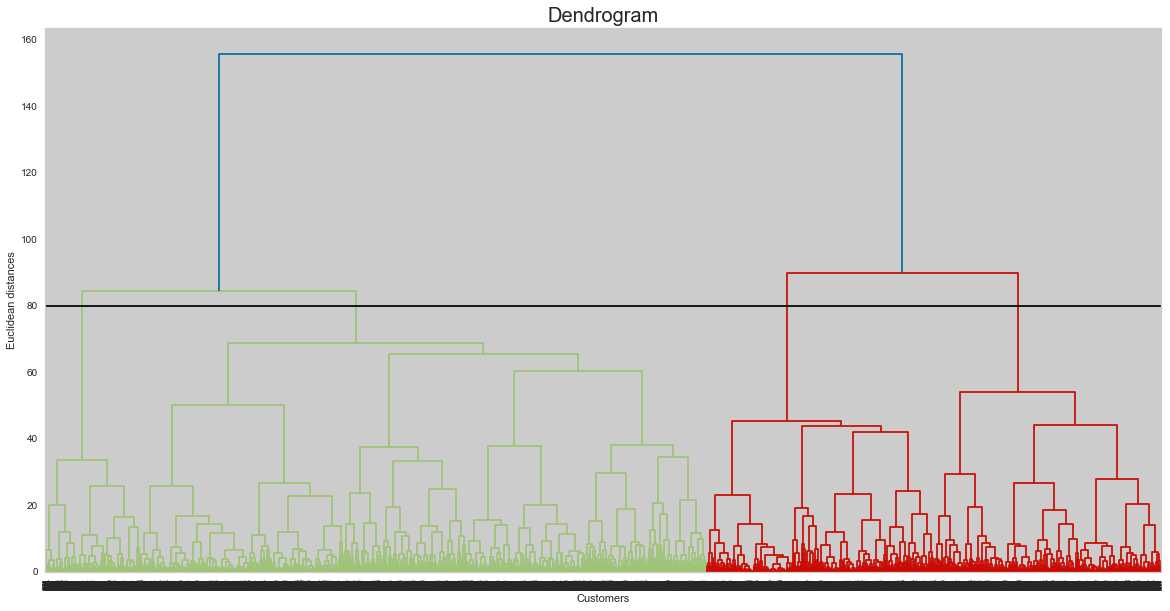

In [34]:
# check the best number of clusters to make using dendrogram
fig = plt.figure(figsize=(20, 10))
plt.title('Dendrogram', fontdict={'size':20})
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
#def llf(id):
#    return '[%s %s %s]' % (df['Gender'][id], df['Graduated'][id], df['Spending_Score'][id])
    
dendro = hierarchy.dendrogram(Z, 
#                              leaf_rotation=0, leaf_font_size=12, orientation='right'
                             )
plt.axhline(y=80, color='black', linestyle='-')

Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

*   Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
*   Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
*   Average linkage minimizes the average of the distances between all observations of pairs of clusters.


In [35]:
agglom = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean')

In [36]:
agglom.fit(df_prepreprocessed)

AgglomerativeClustering(n_clusters=4)

In [37]:
df['Agglomerative Clusters'] = agglom.labels_

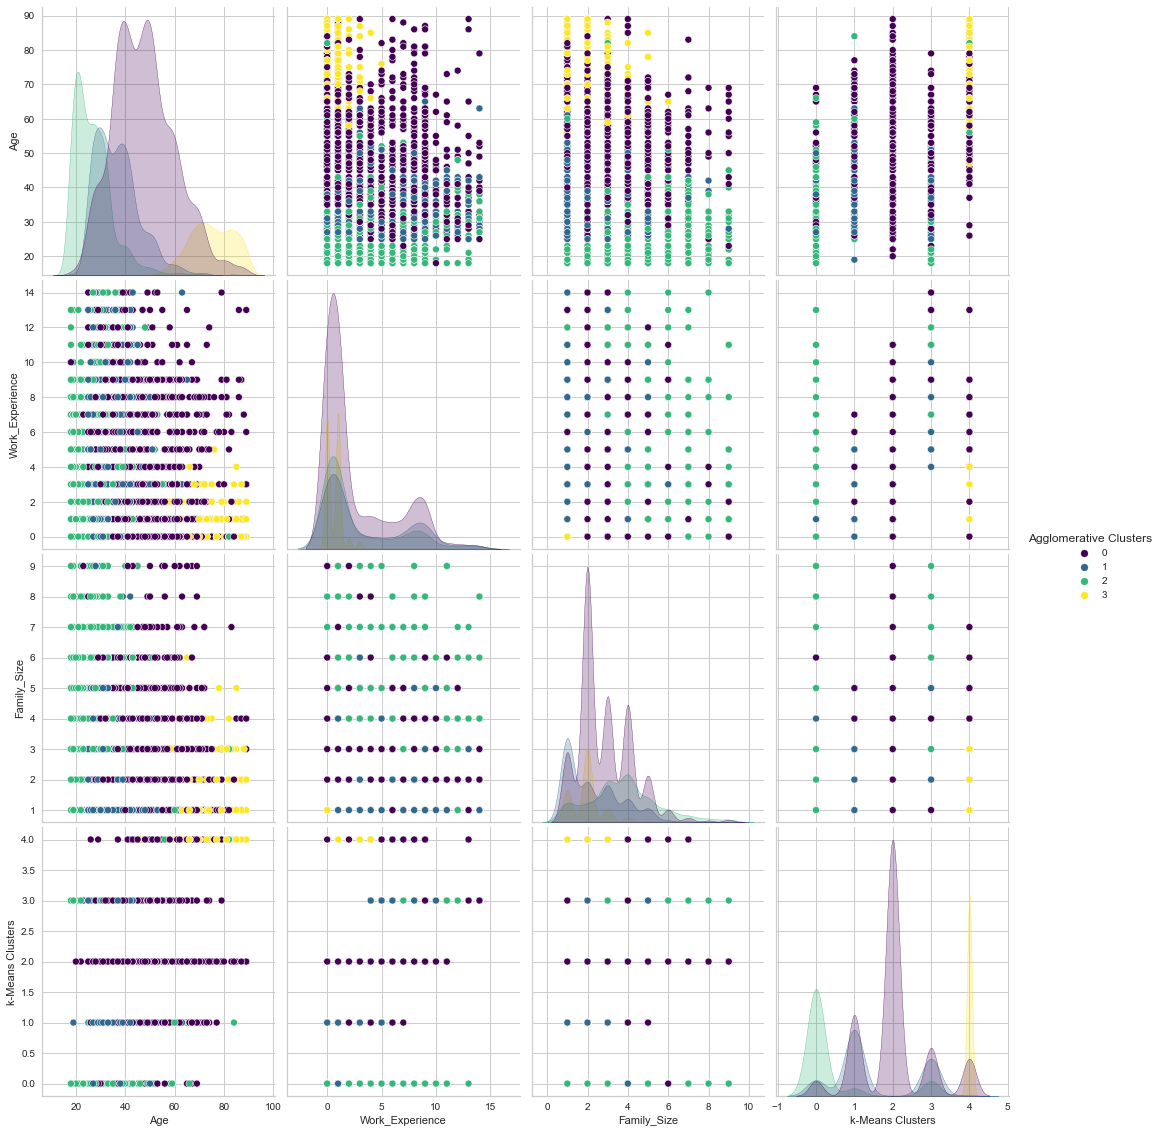

In [38]:
sns.pairplot(df, height=4, hue='Agglomerative Clusters', aspect=0.9, palette='viridis')

In [39]:
fig = px.scatter_3d(df, x='Work_Experience', y='Family_Size', z='Age',
              color='Agglomerative Clusters', color_continuous_scale='Viridis')

fig.show()

### <center> Density-Based Clustering

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190418023034/781ff66c-b380-4a78-af25-80507ed6ff26.jpeg'>

Source: [DBSCAN Clustering in ML | Density based clustering - GeeksforGeeks](https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/) 

"A specific and very popular type of density-based clustering is DBSCAN. DBSCAN is particularly effective for tasks like class identification on a spatial context. The wonderful attributes of the DBSCAN algorithm is that it can find out any arbitrary shaped cluster without getting effected by noise. DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This technique is one of the most common clustering algorithms which works based on density of object. DBSCAN works on the idea that if a particular point belongs to a cluster it should be near to lots of other points in that cluster. It works based on two parameters: radius and minimum points." Unlike the previous techniques, DBSCAN does not need the number of clusters previously informed.

In this algorithm, we have 3 types of data points:
**Core Point**: A point is a core point if it has more than MinPts points within eps. 
**Border Point**: A point which has fewer than MinPts within eps but it is in the neighborhood of a core point. 
**Noise or outlier**: A point which is not a core point or border point.

In [40]:
db = DBSCAN(eps=0.3, min_samples=10)

In [41]:
db.fit(PCA_ds)

DBSCAN(eps=0.3, min_samples=10)

In [42]:
df['DBSCAN Clusters'] = db.labels_

In [43]:
df['DBSCAN Clusters'].unique()

array([ 0,  1, 10, -1,  2,  3,  4, 15,  5,  6,  7, 11,  8,  9, 14, 16, 13,
       12], dtype=int64)

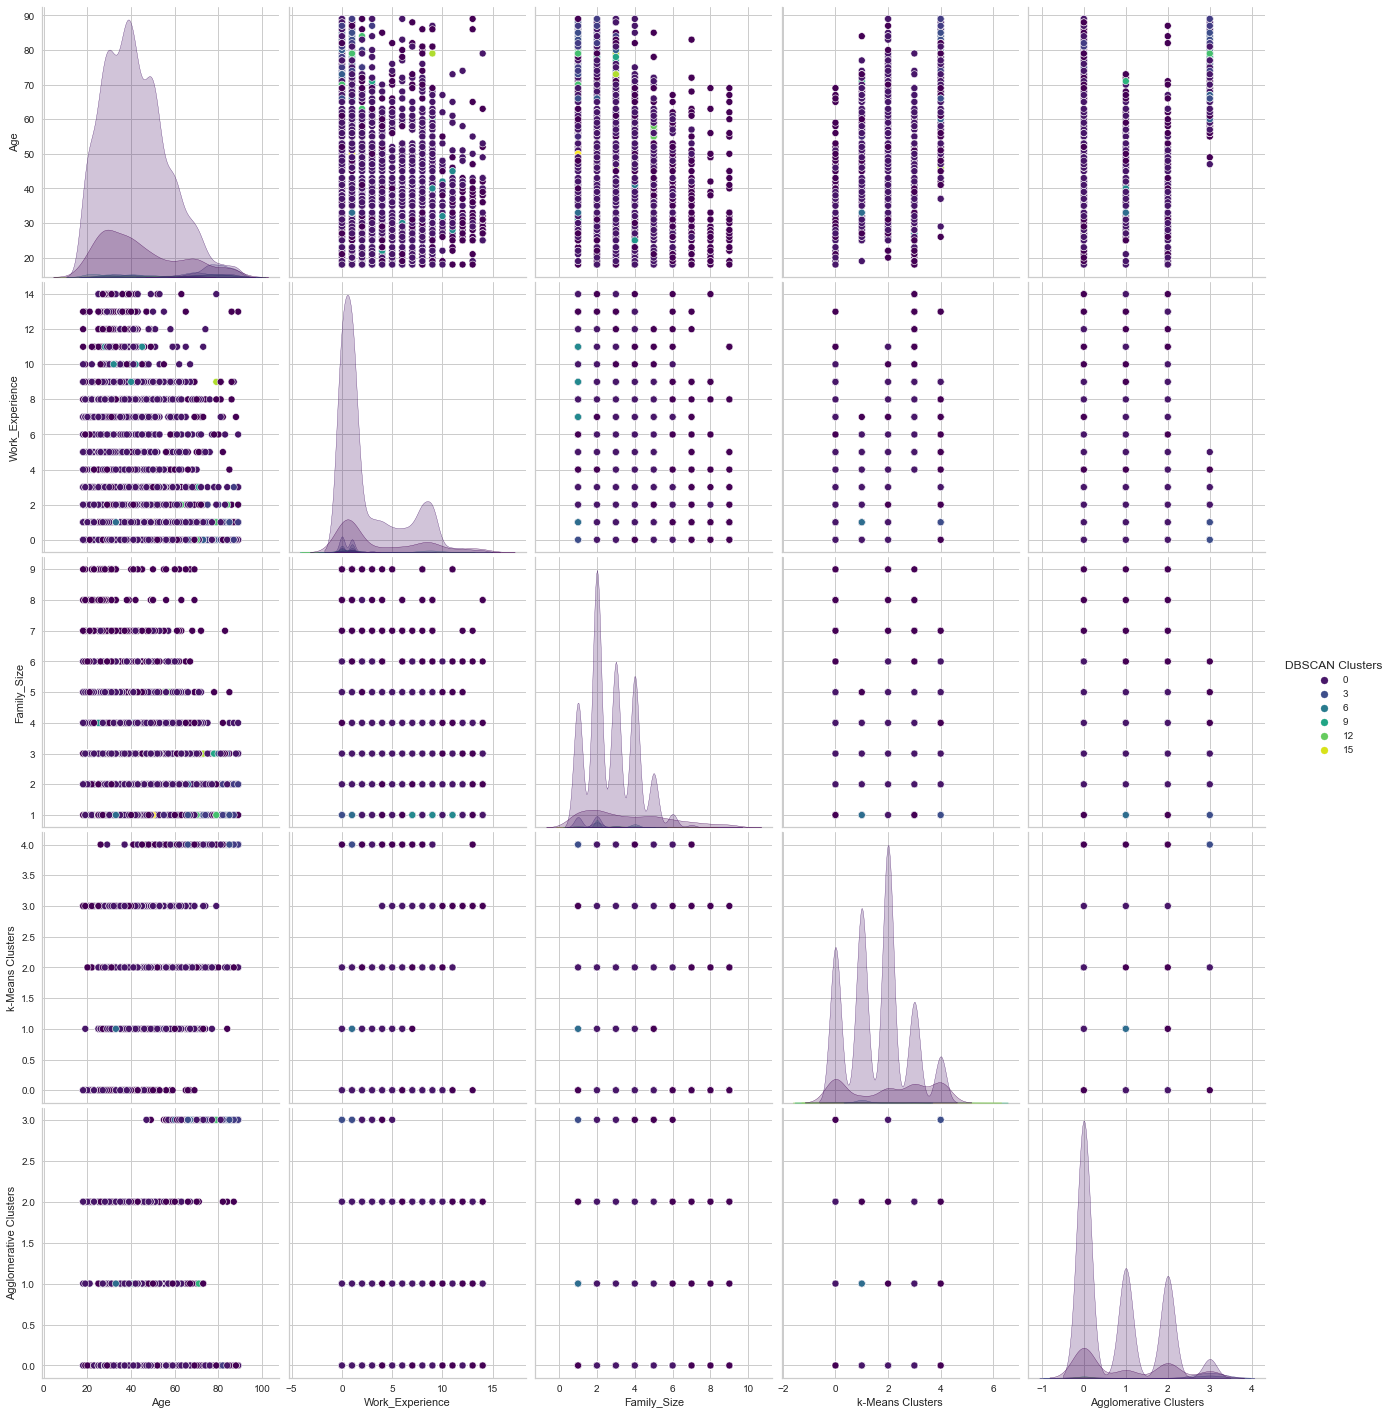

In [44]:
sns.pairplot(df, height=4, hue='DBSCAN Clusters', aspect=0.9, palette='viridis')

In [45]:
fig = px.scatter_3d(df, x='Work_Experience', y='Family_Size', z='Age',
              color='DBSCAN Clusters', color_continuous_scale='Viridis')

fig.show()

### Model Evaluation

Unlike supervised machine learning, unsupervised machine learning does not have a target variable, there is no right answer each model had a different number of clusters, it all depends on what you want to analyze. However, it is important to verify if the separation of the clusters makes sense, for this, the clusters of the k-Means algorithm will be used.

Text(0.5, 1.0, 'Distribution Of The Clusters')

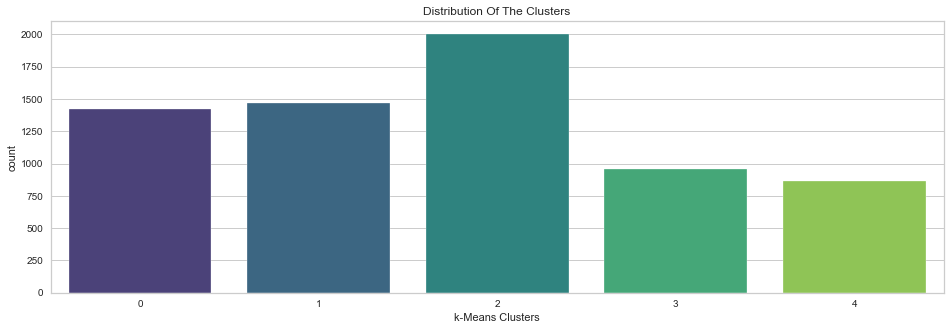

In [46]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["k-Means Clusters"], palette='viridis')
fig.set_title("Distribution Of The Clusters")

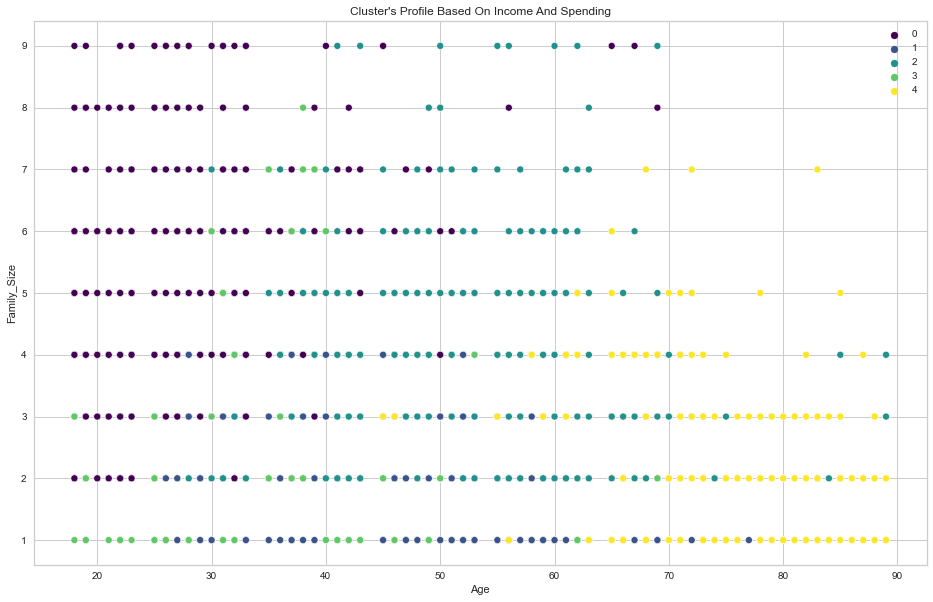

In [47]:
plt.figure(figsize=(16,10)) 
fig = sns.scatterplot(data=df,x=df["Age"], y=df["Family_Size"],hue=df["k-Means Clusters"], palette='viridis')
fig.set_title("Cluster's Profile Based On Income And Spending")
fig.legend()

<AxesSubplot:xlabel='Age', ylabel='Count'>

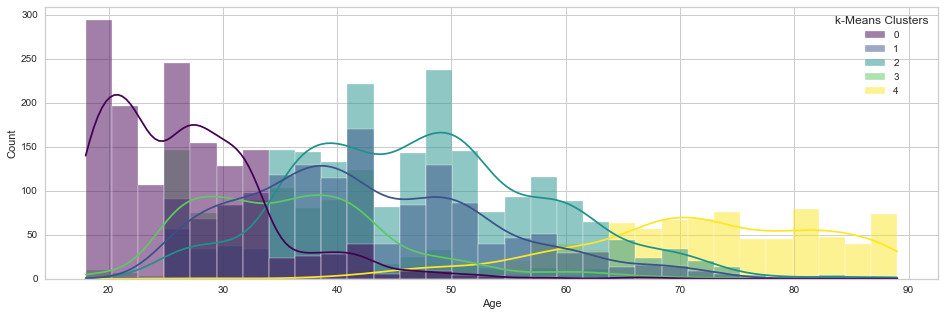

In [48]:
plt.figure(figsize=(16,5)) 
sns.histplot(data=df, x="Age", hue='k-Means Clusters', kde=True, palette='viridis')

Text(0.5, 0, 'Number Of Total per Gender')

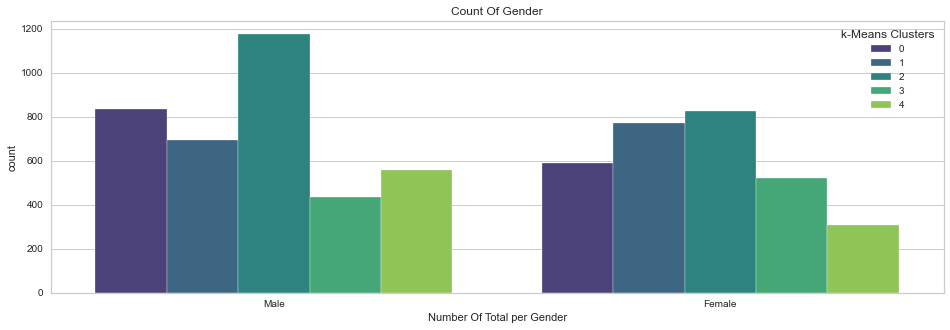

In [49]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df['Gender'],hue=df['k-Means Clusters'], palette='viridis')
fig.set_title("Count Of Gender")
fig.set_xlabel("Number Of Total per Gender")

Text(0.5, 1.0, 'Married Status Distribution by Clusters')

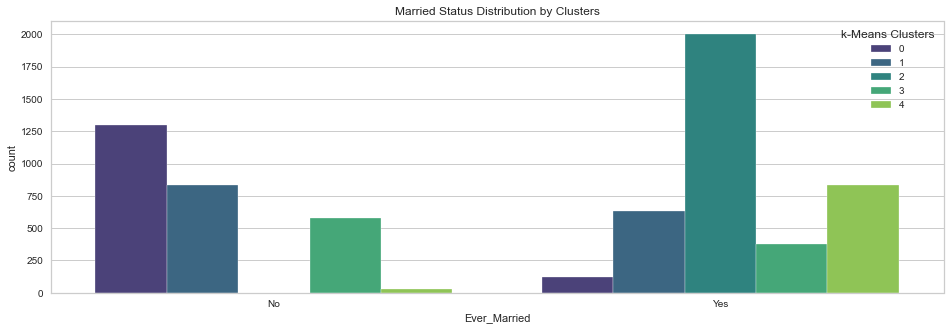

In [50]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["Ever_Married"], hue=df['k-Means Clusters'], palette='viridis')
fig.set_title("Married Status Distribution by Clusters")

Text(0.5, 1.0, 'Profession Distribution by Clusters')

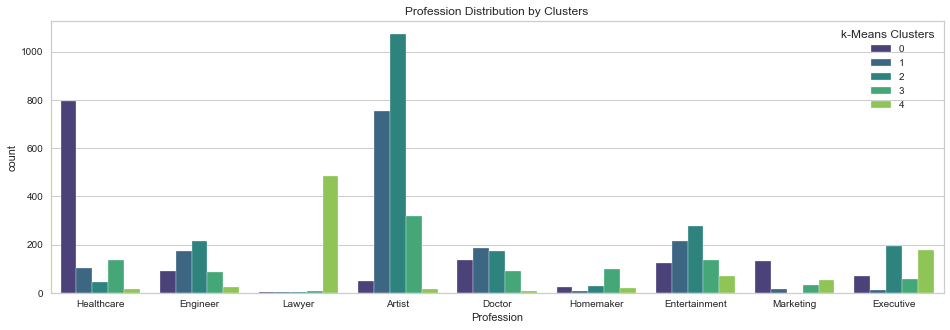

In [51]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["Profession"], hue=df['k-Means Clusters'], palette='viridis')
fig.set_title("Profession Distribution by Clusters")

In [52]:
#for i in df.select_dtypes(['int', 'float']).columns:
#    plt.figure()
#    sns.jointplot(x=df[i], y=df["Family_Size"], hue=df["Clusters"], kind="kde", palette='crest')
#    plt.show()

In [53]:
#fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(13, 40))
#cols = df.select_dtypes('object').columns

#for i, ax in zip(range(16), axes.flat):
#    xtab = pd.crosstab(df[cols[i]], df["k-Means Clusters"], normalize=True)
#    sns.heatmap(100*xtab, annot=True, fmt='.4g', cmap="viridis", ax=ax)
#    ax.set_title(str(cols[i]), fontsize=15)
#    fig.tight_layout()
#plt.show()

In [54]:
df.groupby('k-Means Clusters')[['Age', 'Work_Experience', 'Family_Size']].agg(['mean', 'median', 'min', 'max', 'std'])

Age                           Work_Experience         \
                       mean median min max        std            mean median   
k-Means Clusters                                                               
0                 26.792135   26.0  18  69   7.240108        1.708567    1.0   
1                 42.650545   41.0  19  84  10.910547        1.070845    1.0   
2                 47.451822   47.0  20  89  11.038623        2.116825    1.0   
3                 36.449321   36.0  18  79   9.188450        8.849530    9.0   
4                 71.252887   72.0  26  89  11.444342        1.099307    1.0   

                                      Family_Size                             
                  min   max       std        mean median  min  max       std  
k-Means Clusters                                                              
0                 0.0  13.0  2.429911    4.194522    4.0  1.0  9.0  1.550535  
1                 0.0   7.0  1.370801    1.884196    2.0  1.0  5.0  0.999766  
2                 0.0  11.0  2.761287    3.194708    3.0  1.0  9.0  1.262710  
3                 4.0  14.0  2.077558    2.238245    2.0  1.0  9.0  1.303231  
4                 0.0  13.0  1.849061    2.091224    2.0  1.0  7.0  0.988836

In [55]:
df.groupby(['k-Means Clusters', 'Graduated'])['Graduated'].count().to_frame()

Graduated
k-Means Clusters Graduated           
0                No              1200
                 Yes              224
1                No               174
                 Yes             1294
2                No               429
                 Yes             1574
3                No               262
                 Yes              695
4                No               375
                 Yes              491

In [56]:
df.groupby(['k-Means Clusters', 'Spending_Score'])['Spending_Score'].count().to_frame()

Spending_Score
k-Means Clusters Spending_Score                
0                High                        46
                 Low                       1378
1                High                         5
                 Low                       1463
2                Average                   1590
                 High                       408
                 Low                          5
3                Average                     51
                 High                       102
                 Low                        804
4                Average                     36
                 High                       451
                 Low                        379

In [57]:
#df_combinations = (
#    df.groupby(["k-Means Clusters", "Spending_Score", "Graduated", "Gender"])
#    .size()
#    .reset_index()
#    .rename(columns={0: "Count"})
#)

fig = px.sunburst(
    df,
    path=["k-Means Clusters", "Gender", "Spending_Score", "Graduated"],
    title="Clusters - Sex, Spending Score & Graduated",
    color="k-Means Clusters",
    color_continuous_scale=px.colors.sequential.Viridis,
    height=800,
)
fig.show()

## Profiling

After the formation of the clusters, it's good to see how the customer segmentation was done by the algorithm. Now, the profiles of the clusters formed will be traced and a conclusion will be drawn about the behavior of the customers in each of them, which can help in possible interventions by the company.

Text(0.5, 1.0, 'Profession Distribution by Clusters')

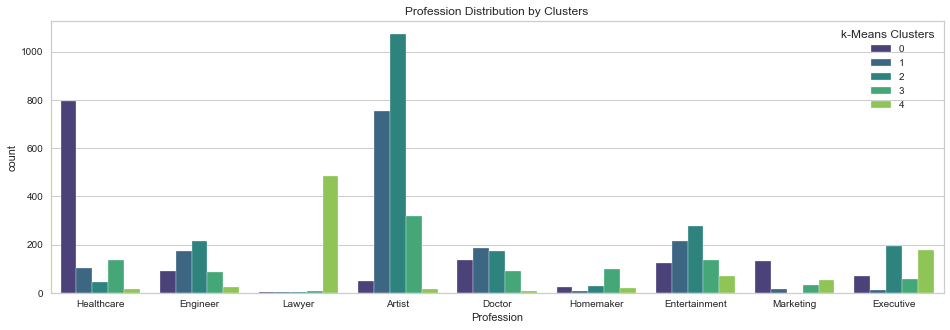

In [58]:
plt.figure(figsize=(16,5)) 
fig = sns.countplot(x=df["Profession"], hue=df['k-Means Clusters'], palette='viridis')
fig.set_title("Profession Distribution by Clusters")

**Points to be noted:**

The following information can be deduced about the customers in different clusters.

- **Cluster 0**
    - formed mostly by healthcare professionals
    - majority low spending score
    - majority are people who were never married
    - most are young adults
    - majority don't have a degree
- **Cluster 1**
    - formed mostly by artists and entertainment professionals
    - most average to hight spending score
    - only those who were already married
    - most middle-aged adults
    - majority have a degree
- **Cluster 2**
    - formed mostly by artists and entertainment professionals
    - majority low spending score
    -
    - span all ages (mostly young adults and middle-aged adults)
    - majority have a degree
- **Cluster 3**
    - formed mostly by artists, doctor and entertainment professionals
    - majority low spending score
    -
    - span all ages (mostly young adults and middle-aged adults)
    - most don't have a degree
- **Cluster 4**
    - formed mostly by lawyers and executive professionals
    - balanced spending score
    - majority are people who were married
    - most are elderly
    - balanced higher education level

## <center> References

* [Machine Learning with Python - Introduction to Machine Learning | Coursera](https://www.coursera.org/learn/machine-learning-with-python)
* [Customer Segmentation: Clustering 🛍️🛒🛒 | Kaggle](https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering/)